In [1]:
import pandas as pd
import numpy as np
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, Masking,BatchNormalization, CuDNNLSTM
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

Using TensorFlow backend.
/Users/ambroiserenaud/anaconda3/envs/chili/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ambroiserenaud/anaconda3/envs/chili/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ambroiserenaud/anaconda3/envs/chili/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [34]:

vocab = [
         '_O',
         '_C',
         '_T',
         'OT',
         'CO',
         'CT', ]

labels = ['correct',
          'wrong',
          'type',
          'orientation',
          'color']

types = ['INTRO',
         'CORE',
         'FLEX',
         'TRIK',
         'DELY'
]

topics = ['cards',
          'animals',
          'geometry'
    
]

feat = ['type',
        'color',
        'orientation',
        'dual'
]

age = ['8-10','11-13']

In [54]:
def seq_to_int(qts,vocab, labels, types, feat, topics, n_steps, age):
    integ = list()
    for i,x in enumerate(qts):
        if i != n_steps:
            features = list()
            features.append(vocab.index(qts[i, 4]))
            features.append(qts[i, 2])
            features.append(types.index(qts[i, 9]))
            #features.append(feat.index(qts[i, 10]))
            features.append(topics.index(qts[i, 6]))
            #features.append(age.index(qts[i, 7]))
            features.append(labels.index(qts[i, 5]))
        else:
            features = list()
            features.append(vocab.index(qts[i, 4]))
            features.append(qts[i, 2])
            features.append(types.index(qts[i, 9]))
            #features.append(feat.index(qts[i, 10]))
            features.append(topics.index(qts[i, 6]))
            #features.append(age.index(qts[i, 7]))
            features.append(99)
        integ.append(features)
    return integ

def split_sequence(data, n_steps, vocab, labels, types, feat, topics, age):
    X, Y = list(), list()
    users = list(dict.fromkeys(data.loc[:, "user"]))
    for u in users:
        sequence = data[data.user == u]
        for i in range(len(sequence)):
            end_idx = i + n_steps
            if end_idx > len(sequence)-1:
                break
            x = seq_to_int(sequence.iloc[i:end_idx+1, :].values, vocab, labels, types, feat, topics, n_steps, age)
            y = labels.index(str(sequence.iloc[end_idx, 5]))
            X.append(x)
            Y.append(y)
    return np.array(X), np.array(Y)

In [75]:
from keras.utils import to_categorical
data_train = pd.read_csv('train.csv').iloc[:, :]
data_train['question'] = data_train['question'].apply(lambda x : x[-2]+x[-1])
#data_train = data_train[data_train.topic == 'cards']
y_train = list()
X_train = list()


for i in tqdm(range(10,18)):
    X_seq, y_seq = split_sequence(data_train, i, vocab, labels, types, feat, topics, age)
    for x in X_seq:
        X_train.append(x)
    for _y in y_seq:
        y_train.append(_y)
#y_train = np_utils.to_categorical(y_train)
y_train = to_categorical(np.asarray(y_train))
X_train = np.asarray(X_train)
X_train = pad_sequences(X_train, value=99)

100%|██████████| 8/8 [00:28<00:00,  3.59s/it]


In [76]:
from keras.utils import to_categorical
data_val = pd.read_csv('validation.csv').iloc[:, :]
data_val['question'] = data_val['question'].apply(lambda x : x[-2]+x[-1])
y_val = list()
X_val = list()


for i in tqdm(range(10,18)):
    X_seq, y_seq = split_sequence(data_val, i, vocab, labels, types, feat, topics, age)
    for x in X_seq:
        X_val.append(x)
    for _y in y_seq:
        y_val.append(_y)
#y_train = np_utils.to_categorical(y_train)
y_val = to_categorical(np.asarray(y_val))
X_val = np.asarray(X_val)
X_val = pad_sequences(X_val, value=99)

100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


In [77]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
import keras
# updatable plot
# a minimal example (sort of)

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()




## LSTM

In [78]:
amsgrad = Adam(amsgrad=False)

model = Sequential()
model.add(Masking(mask_value=99))
model.add(LSTM(units=100, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

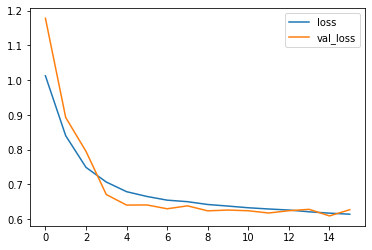

Epoch 17/100
20416/59764 [=========>....................] - ETA: 47:04 - loss: 0.6017 - acc: 0.6656

KeyboardInterrupt: 

In [79]:

history = model.fit(X_train, y_train, epochs=100, batch_size=64, shuffle=False, verbose=1, validation_data=(X_val, y_val), callbacks=[plot_losses])
model.summary()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

## CNN-LSTM

In [58]:
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
print(X_train.shape)

(59764, 18, 5)


In [67]:
n_steps, n_length = 3, 6
n_features = 5
X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
X_val = X_val.reshape((X_val.shape[0], n_steps, n_length, n_features))

In [68]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [70]:
history = model.fit(X_train, np.asarray(y_train), epochs=100, batch_size=64, shuffle=True, verbose=1, validation_data=(X_val, y_val), callbacks=[plot_losses])
model.summary()

Train on 59764 samples, validate on 5940 samples
Epoch 1/100
 8832/59764 [===>..........................] - ETA: 32s - loss: 1.0680 - acc: 0.3895

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

## ConvLSTM

In [81]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# reshape into subsequences (samples, time steps, rows, cols, channels)
n_steps, n_length = 3, 6
n_features = 5
X_train = X_train.reshape((X_train.shape[0], n_steps, 1, n_length, n_features))
X_val = X_val.reshape((X_val.shape[0], n_steps, 1, n_length, n_features))

In [82]:
from keras.layers import ConvLSTM2D
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

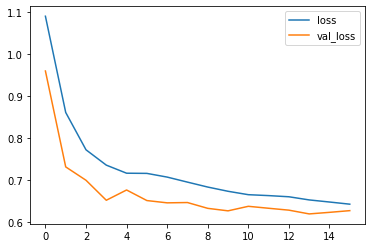

Epoch 17/100
39616/59764 [==================>...........] - ETA: 17s - loss: 0.6454 - acc: 0.6395

KeyboardInterrupt: 

In [83]:
history = model.fit(X_train, np.asarray(y_train), epochs=100, batch_size=64, shuffle=True, verbose=1, validation_data=(X_val, y_val), callbacks=[plot_losses])
model.summary()